In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chargement des données
url = "/content/heart.csv"
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
data = pd.read_csv(url, names=column_names)

# Nettoyage des données
data.replace("?", np.nan, inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


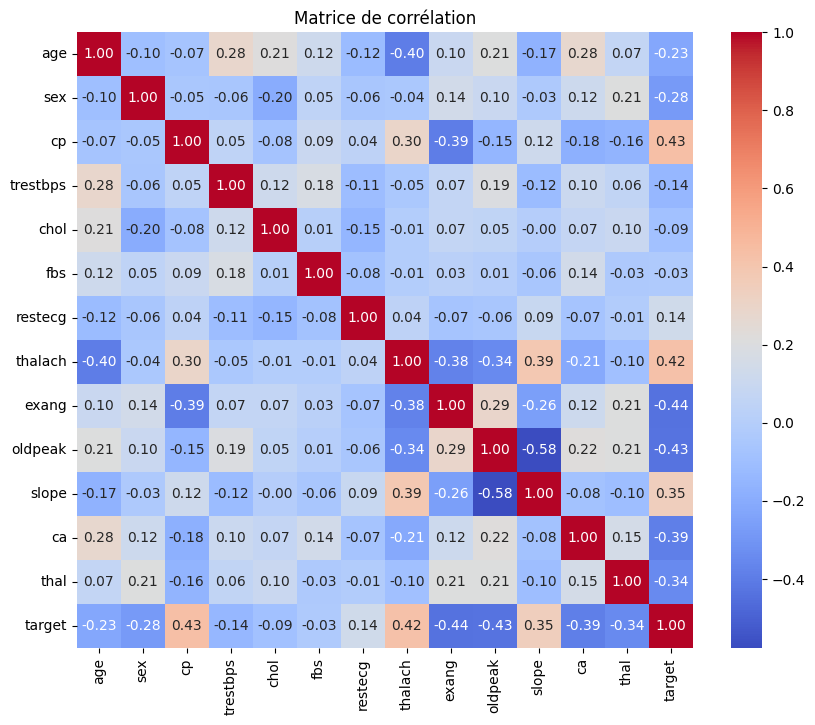

In [ ]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation")
plt.show()

In [ ]:
# Préparation des données
X = data.drop("target", axis=1)
y = data["target"]
y = y.apply(lambda x: 1 if x > 0 else 0)  # Binarisation de la variable cible

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Analyse en composantes principales (ACP)
pca = PCA(n_components=2)  # Réduction à 2 dimensions pour visualisation
X_pca = pca.fit_transform(X_scaled)

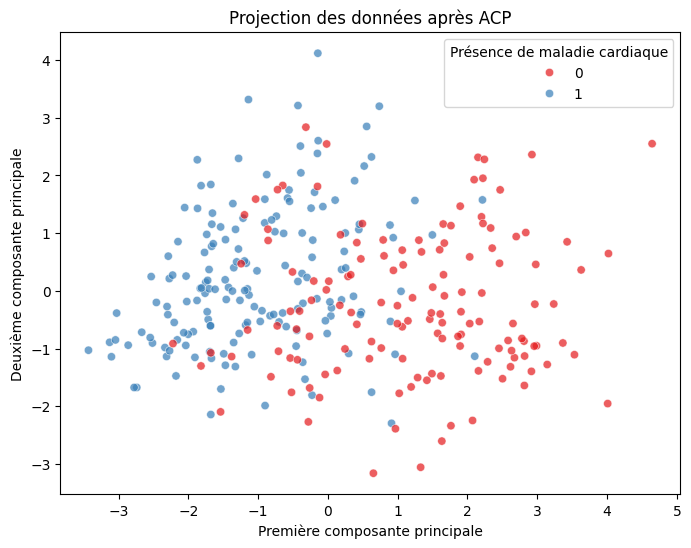

In [ ]:
# Visualisation des deux premières composantes principales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1", alpha=0.7)
plt.title("Projection des données après ACP")
plt.xlabel("Première composante principale")
plt.ylabel("Deuxième composante principale")
plt.legend(title="Présence de maladie cardiaque", loc="best")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement du modèle Random Forest (base)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = rf_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_pred, rf_model.predict_proba(X_test)[:, 1]))

Confusion Matrix:
[[24  5]
 [ 5 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


Accuracy Score: 0.8360655737704918
AUC-ROC Score: 1.0


In [ ]:
# Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres et meilleur score
print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score obtenu :", grid_search.best_score_)

# Évaluation du modèle optimisé
best_rf_model = grid_search.best_estimator_
y_pred_optimized = best_rf_model.predict(X_test)

print("\nConfusion Matrix (Optimized Model):")
print(confusion_matrix(y_test, y_pred_optimized))
print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, y_pred_optimized))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres trouvés : {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Meilleur score obtenu : 0.8141156462585034

Confusion Matrix (Optimized Model):
[[25  4]
 [ 5 27]]

Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chargement des données
url = "/content/heart.csv"
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
data = pd.read_csv(url, names=column_names)

# Nettoyage des données
data.replace("?", np.nan, inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)



Accuracy : 0.7869
Précision : 0.8065
Rappel : 0.7812
F1-score : 0.7937
Facteur de détermination (R^2) : 0.4188


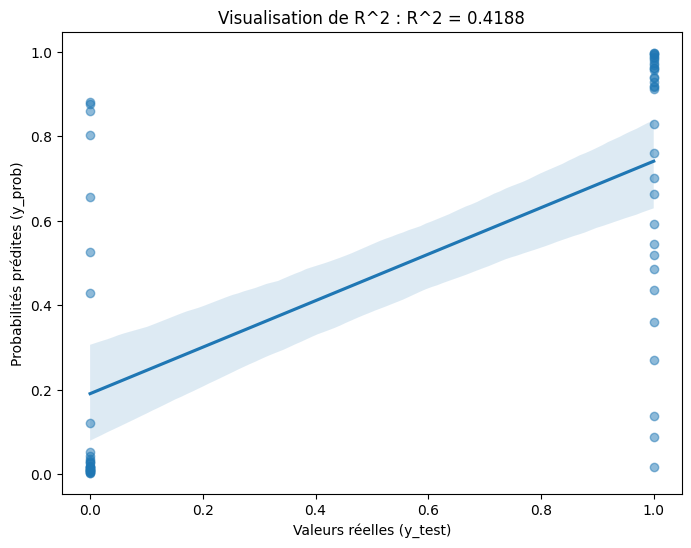

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, precision_score, recall_score, f1_score
# Préparation des données
X = data.drop("target", axis=1)
y = data["target"]
y = y.apply(lambda x: 1 if x > 0 else 0)  # Binarisation de la variable cible

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement d'un modèle Gradient Boosting Classifier (base)
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Calcul des métriques de classification
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
r2 = r2_score(y_test, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Rappel : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Facteur de détermination (R^2) : {r2:.4f}")

# Visualisation de R^2 : Régression entre les probabilités prédites et les valeurs réelles
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_prob, logistic=False, scatter_kws={"alpha": 0.5})
plt.title(f"Visualisation de R^2 : R^2 = {r2:.4f}")
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Probabilités prédites (y_prob)")
plt.show()



In [ ]:
# Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres et meilleur score
print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score obtenu :", grid_search.best_score_)

# Évaluation du modèle optimisé
best_gb_model = grid_search.best_estimator_
y_pred_optimized = best_gb_model.predict(X_test)
y_prob_optimized = best_gb_model.predict_proba(X_test)[:, 1]




Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Meilleurs paramètres trouvés : {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score obtenu : 0.8261904761904761


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score # Import accuracy_score

# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))

# Support Vector Machine
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svc_pred))

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))

Logistic Regression Accuracy: 0.8524590163934426
SVM Accuracy: 0.8688524590163934
KNN Accuracy: 0.9180327868852459


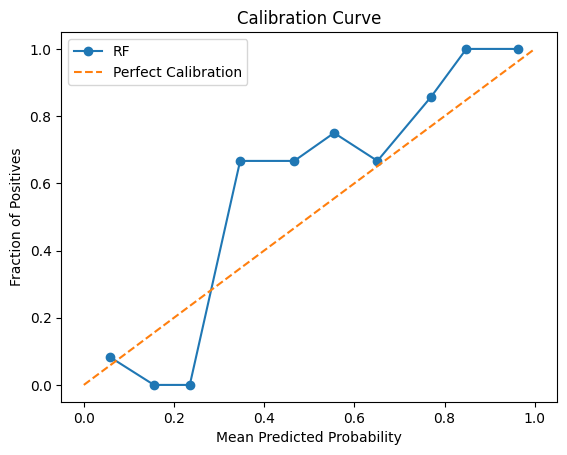

In [ ]:
from sklearn.calibration import calibration_curve

# Calibration for RF
prob_rf = rf_model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_prob = calibration_curve(y_test, prob_rf, n_bins=10)

plt.plot(mean_predicted_prob, fraction_of_positives, marker='o', label="RF")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.title("Calibration Curve")
plt.show()

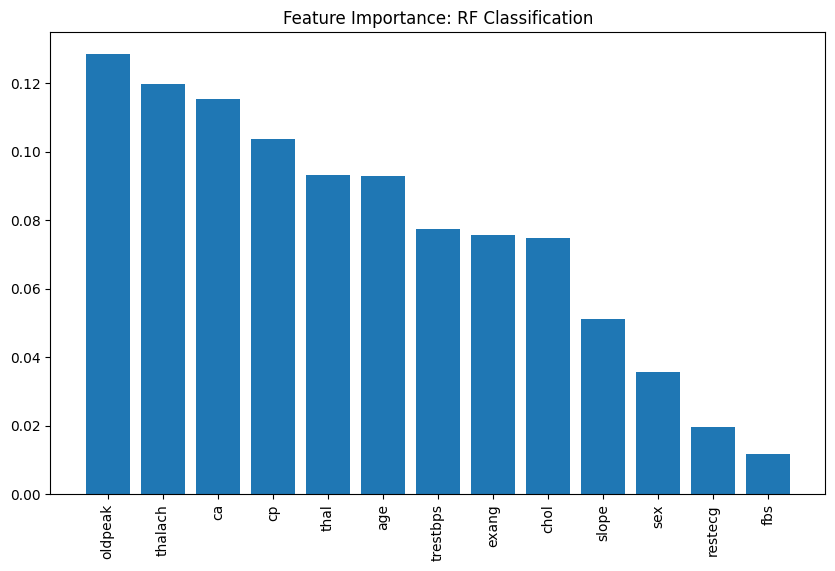

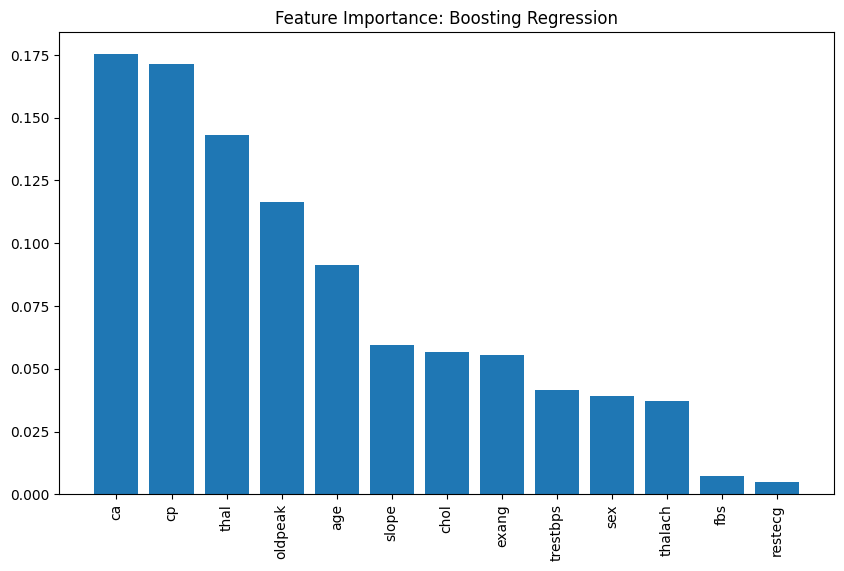

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance for RF classification
importance_class = rf_model.feature_importances_
indices_class = np.argsort(importance_class)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importance_class[indices_class])
plt.xticks(range(X.shape[1]), X.columns[indices_class], rotation=90)
plt.title("Feature Importance: RF Classification")
plt.show()

# Feature importance for Boosting regression
importance_reg = gb_model.feature_importances_
indices_reg = np.argsort(importance_reg)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importance_reg[indices_reg])
plt.xticks(range(X.shape[1]), X.columns[indices_reg], rotation=90)
plt.title("Feature Importance: Boosting Regression")
plt.show()
